# Analyze experiments
Run the post-processing needed to compare different runs.

In [1]:
%matplotlib inline
from fff.learning.gc.functions import GCSchNetForcefield
from matplotlib import pyplot as plt
from collections import defaultdict
from shutil import rmtree
from pathlib import Path
from tqdm import tqdm
from ase.io import read
import pandas as pd
import numpy as np
import torch
import json

/home/lward/miniconda3/envs/multisite/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
run_dir = Path('../runs/dft-md-23Feb05-014653-7dc17b/')

## Load in the Results
We want the runtimes and system hostnames so we can measure how many tasks are running concurrently

In [3]:
def load_results(path: Path) -> pd.DataFrame:
    """Load the results for a certain run
    
    Args:
        path: Path to the run
    Returns:
        Dataframe of all results
    """
    
    # Loop over inference, training, and simulation
    output = []
    for task in ['inference', 'training', 'simulation', 'sampling']:
        # Get the results
        data = path / f'{task}-results.json'
        assert data.is_file(), f'{data} does not exist'
        results = pd.read_json(path / f'{task}-results.json', lines=True)
        
        # Store make some metadata easier to get
        results['task'] = task
        results['hostname'] = results['worker_info'].apply(lambda x: x.get('hostname', 'nidXXXXX') if x is not None else 'nidXXXXX')
        
        # Mark the machine running
        def _get_machine(hostname):
            if hostname.startswith('lambda'):
                return 'lambda'
            elif hostname.startswith('nid'):
                return 'theta'
            elif hostname.startswith('thetagpu'):
                return 'thetagpu'
            elif hostname.startswith('venti'):
                return 'venti'
            else:
                return hostname
        results['machine'] = results['hostname'].apply(_get_machine)
                
        # Make a shorter name for the task type
        def _get_task(method):
            if method == 'run_calculator':
                return 'simulation'
            elif method.startswith('evaluate'):
                return 'inference'
            elif 'train' in method:
                return 'training'
            else:
                return 'sampling'
        
        results['task_type'] = results['method'].apply(_get_task)
        output.append(results)
        
    # Return sorted by 
    output = pd.concat(output)
    output.sort_values('time_compute_started', inplace=True, ignore_index=True)
    return output

In [4]:
results = load_results(run_dir)

Load in the metadata

In [5]:
metadata = json.loads((run_dir / 'runparams.json').read_text())

## Plot the Utilization over Time
Without factoring out queue times.

First step is to mark when the utilization changes (at the beginning and end of jobs)

In [6]:
def get_utilization_over_time(results: pd.DataFrame) -> pd.DataFrame:
    """Get the utilization of all machines over time.
    
    Args:
        results: Result data for all tasks
    Returns:
        Utilization of each system over time
    """
    
    # Store the times at which tasks begin or end
    steps = []
    for rid, task in results.iterrows():
        for t, c in zip([task['time_compute_started'], 
                         task['time_compute_started'] + task['time_async_resolve_proxies'] + task['time_deserialize_inputs'] + task['time_running'] + task['time_serialize_results']],
                        [1, -1]):
            steps.append({
                'task_type': task['task_type'],
                'timestamp': t,
                'machine': task['machine'],
                'hostname': task['hostname'],
                'change': c
            })
    
    # Sort by timestamp
    steps = pd.DataFrame(steps)
    steps.sort_values('timestamp', inplace=True, ignore_index=True)
    
    # Normalize the walltimes for the results and the 
    steps['walltime'] = steps['timestamp'] - steps['timestamp'].min()
    results['walltime'] = results['time_result_received'] - steps['timestamp'].min()
    
    # Get the utilization for machine and by task
    machines = list(set(steps['machine']))
    task_types = set(steps['task_type'])
    total_used = dict((x, 0) for x in list(machines) + list(task_types))
    utilization = []
    for rid, row in steps.iterrows():
        total_used[row['machine']] += row['change']
        total_used[row['task_type']] += row['change']
        utilization.append(total_used.copy())
    utilization = pd.DataFrame(utilization)
    utilization['total'] = utilization[machines].sum(axis=1)
    
    # Append it to the tracking
    utilization = pd.concat((steps, utilization), axis=1)
    
    return utilization

In [7]:
utilization = get_utilization_over_time(results)

Factor out the idle times (due to jobs waiting in queue)

In [8]:
def remove_queue_times(utilization: pd.DataFrame, results: pd.DataFrame, minimum_span=60):
    """Remove the times the system was stuck waiting for nodes to be available
    
    Args:
        utilization: Dataframe containing the utilization over time
        results: Dataframe containing the task information
        minimum_span: Minimum time to declare a utilization absence due to queues
    """
    
    # Get the times where the system is completely idle
    stop_use = utilization.query('total==0').index[0:-1]  # Last one is shutdown
    
    # Find those where the downtime is honger than the minimum span
    is_longer = (utilization.loc[stop_use + 1, 'walltime'].values - utilization.loc[stop_use, 'walltime']) > minimum_span
    queue_stops = stop_use[is_longer]
    
    # Compute the time spent in queue for each pause
    queue_times = utilization.loc[queue_stops + 1, 'walltime'].values - utilization.loc[queue_stops, 'walltime']
    
    # Remove that time from jobs that occur after each time
    queue_starts = utilization.loc[queue_stops, 'walltime']
    for frame in (utilization, results):
        frame['time_queueing'] = 0
        for queue_start, queue_time in zip(queue_starts, queue_times):
            frame.loc[frame['walltime'] > queue_start, 'time_queueing'] += queue_time
        
        frame['walltime'] -= frame['time_queueing']
remove_queue_times(utilization, results)

Plot by the machine and task type

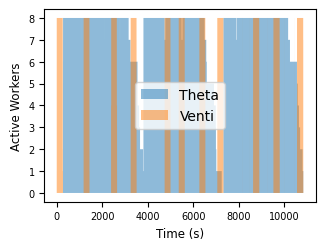

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for machine in set(results['machine']):
#    if machine != "thetagpu": continue
    ax.fill_between(utilization['walltime'], utilization[machine], step='post', label=machine.capitalize(), alpha=0.5)

#ax.set_xlim(0, 100)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Active Workers')
#ax.set_xlim(2500, 2600)

ax.legend(loc='center')
fig.savefig('figures/theta-utilization.png', dpi=320)

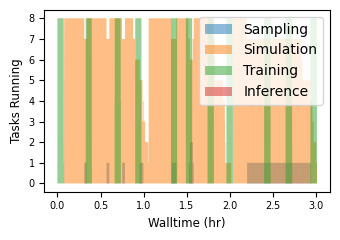

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for task_type in set(results['task_type']):
    ax.fill_between(utilization['walltime'] / 3600, utilization[task_type], step='post', label=task_type.capitalize(), alpha=0.5)

#ax.set_xlim(0, 0.3)
#ax.set_ylim(0, 8)


ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('Tasks Running')

ax.legend()
fig.tight_layout()

## Compute System Utilization
We are targeting HPC systems where nodes are allocated in blocks. That means you get charged for the full block regardless of how many jobs are running. 

The following function computes the resource costs under this condition

In [11]:
def compute_cost(utilization: pd.DataFrame, results: pd.DataFrame, idletime: float = 120): 
    """Compute the charge from a supercomputer center based on utilization
    
    We get charged for all nodes enven if you're not using them.
    
    Args:
        utilization: Dataframe containing the utilization over time
        results: Dataframe containing 
        idletime: How long to wait before halting charges on a ndoe
    """
    # Process each machine separately
    for machine, group in utilization.groupby('machine'):
        # Mark the points idletime after the machine just became idle
        ref_points = group[np.all(np.stack([
            group.change < 0,
            group[machine] == 0,
            np.logical_not(group.walltime.isnull())
        ], axis=1), axis=1)].timestamp + idletime
        
        # Combine these with the points where the machine had at least one task
        #  to determine the "Active Spans" where there has been an unbroken time
        #  between when the machine was active with brakes smaller than the overall
        active_starts = group[np.logical_and(
            group[machine] > 0,
            np.logical_not(group.walltime.isnull())
        )].timestamp
        active_times = np.sort(np.hstack([active_starts, ref_points]))
        
        # Find the points where the times between an "active" point is greater than the idletime
        #  These are where a job started.
        elapsed = np.diff(active_times)
        start_points = np.where(elapsed > idletime)[0] + 1
        
        # Get the time where the last job ended
        end_points = start_points - 1
        
        # Record these spans knowning that the first activity period started at the first point
        #  and the last active period ended at the last actiity time
        if len(start_points) == 0:
            continue
        spans = list(zip(active_times[start_points],
                         active_times[end_points[1:]]))
        spans.insert(0, (active_times[0], active_times[end_points[0]]))
        spans.append((active_times[start_points[-1]], active_times[-1]))
        
        # Sort by the time 
        spans = np.array(spans)
        assert np.all(spans[1:, 0] >= spans[:-1, 1])
        assert np.all(np.diff(spans[:, 0]) > 0)
        assert np.all(spans[:, 1] >= spans[:, 0]), spans[:, 1] - spans[: , 0]
        
        # Use these to compute the amount of elapsed resource utilization for each result
        node_count = group[machine].max()
        def _get_time_used(x: float) -> float:
            """Get the amount of compute used up to a certain point"""
            output = 0
            
            # If the compute hasn't been used yet
            if x < spans[0][0]:
                return 0
            
            # Add up from all of the previous spans
            for span in spans:
                if x > span[1]:
                    output += node_count * (span[1] - span[0])
                elif x > span[0]:
                    output += node_count * (x - span[0])
            return output / 3600
        results[f'{machine}_usage'] = results['time_result_received'].apply(_get_time_used)
compute_cost(utilization, results)

Plot the usage over time

Text(0, 0.5, 'Resources Used')

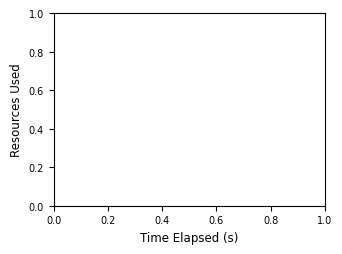

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

start_time = results['time_created'].min()
results.sort_values('time_result_received', inplace=True)
#ax.step(results['time_result_received'] - start_time, results['bettik-linux_usage'])

ax.set_xlabel('Time Elapsed (s)')
ax.set_ylabel('Resources Used')

## Get the Overhead per Task
Compute the time not spent running as task

In [13]:
def get_overhead_times(results: pd.DataFrame) -> pd.DataFrame:
    """Get the time spent doing things besides running tasks.
    
        - Starting: Time taken to start a task on a workflow system
        - Serialization: Time taken to serialize results
        - Reporting: Time taken for the completed, serialized task to be reported
    
    Args:
        results: Results file
    Returns:
        Many different analyses for each type of tasks. These include
    """
    
    # Load in all of the tasks
    tasks = results.copy()
    
    # Load compute the total proxy resolution time for inputs
    def _get_resolve_time(x):
        if x is None or len(x) == 0: 
            return 0
        return sum(x['resolve']['avg_time_ms'] * x['resolve']['calls'] for x in x.values() if 'resolve' in x) / 1000
    tasks['time_input_resolution'] = tasks['proxy_timing'].apply(_get_resolve_time)
    
    # Get the time waiting for the result to show up
    def _get_resolve(x):
        if 'result_proxy_stats' not in x or 'resolve' not in x['result_proxy_stats']:
            return 0
        return x['result_proxy_stats']['resolve']['avg_time_ms'] / 1000
    tasks['time_output_resolution'] = tasks['task_info'].apply(_get_resolve)
    
    # Get the total overhead
    #  Total elapsed: (Result received + + all outputs resolved) - time started
    #  Total running: Time running - time to resolve inputs
    tasks['overhead_total'] = tasks['time_result_received'] - tasks['time_created'] - (tasks['time_running'] - tasks['time_input_resolution'])
    tasks['overhead_sending'] = tasks['time_compute_started'] - tasks['time_created'] - tasks['time_serialize_inputs'] + tasks['time_input_resolution']
    
    # Compute the time compute finished
    tasks['time_compute_done'] = tasks['time_compute_started'] + tasks['time_deserialize_inputs'] + tasks['time_async_resolve_proxies'] + tasks['time_running']
    
    # Compute the difference between the completion time and when it was received by the thinker
    serialization_cols = [c for c in tasks.columns if 'serialize' in c]
    tasks['overhead_serialization'] = tasks[serialization_cols].sum(axis=1)
    
    # Compute the receiving component
    tasks['overhead_reporting'] = tasks['time_result_received'] - tasks['time_compute_done'] + tasks['time_output_resolution']
    
    # Only return a subset of the calculations
    overhead_cols = [c for c in tasks.columns if c.startswith('overhead')]
    return tasks[['method', 'machine', 'time_created', 'time_running', 'time_input_resolution', 'time_output_resolution'] + overhead_cols]
get_overhead_times(results).query('method=="train"').describe()

,time_created,time_running,time_input_resolution,time_output_resolution,overhead_total,overhead_sending,overhead_serialization,overhead_reporting
count,8.800000e+01,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,1.675567e+09,263.517892,0.399602,0.003020,4.235619,4.133578,0.072310,0.054244
std,3.478001e+03,6.741802,0.123217,0.013423,7.499237,7.418741,0.093162,0.068624
min,1.675562e+09,251.162853,0.016429,0.000945,0.380166,0.336624,0.017283,0.026320
25%,1.675564e+09,256.945392,0.359220,0.001128,0.454065,0.413609,0.021374,0.037844
50%,1.675567e+09,263.114806,0.404902,0.001323,0.505969,0.456275,0.023760,0.040661
75%,1.675571e+09,268.617789,0.451630,0.001732,0.768343,0.643190,0.028640,0.043847
max,1.675573e+09,276.921139,0.670530,0.127194,23.477535,23.231129,0.304321,0.447293


## Get the Final Model Performance
See how well the model produced using all of the data works on a molecular dyanmics challenge problem.

In [14]:
log = pd.read_csv(run_dir / 'final-model' / 'train_log.csv')

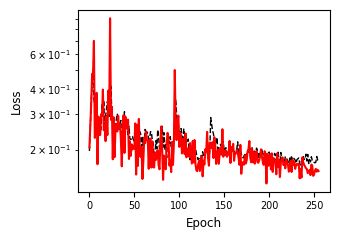

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(log['epoch'], log['train_loss_total'], '--', color='k', lw=1, label='Train')
ax.plot(log['epoch'], log['valid_loss_total'], '-', color='r', label='Validation')

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

In [16]:
def compare_against_benchmark(run_dir: Path) -> pd.DataFrame:
    """Compare the performance of the final model against some benchmark data
    
    Args:
        run_dir: Path to the run directory
        theory: Name of the theory used to train the model
        
    Returns:
        ML and DFT energies for each frame
    """
    
    # Load in the model
    model_path = run_dir / 'final-model' / 'model'
    if not model_path.exists():
        raise ValueError('Final model has not been trained')
    model = torch.load(model_path, map_location='cpu')
    
    # Load in the metadata
    run_params = json.loads((run_dir / 'runparams.json').read_text())
    
    # Load in the initial model
    init_model_path = '../../data/forcefields/starting-model/tuned/model'
    init_model = torch.load(init_model_path, map_location='cpu')
    
    # Make the interface to running the models
    schnet = GCSchNetForcefield()
    
    # Loop over the benchmarks
    test_set_dir = Path('../../data/forcefields/introduce-methane/trajectories/')
    output = defaultdict(list)
    for db in test_set_dir.glob(f'*db'):
        # Read in the test data
        atoms = read(db, ':')
        output['traj'].extend([db.name[:-3]] * len(atoms))
        output['frame'].extend(range(len(atoms)))
        
        # Store the true values
        dft_energy = [a.get_potential_energy() for a in atoms]
        output['energy_dft'].extend(dft_energy)
        dft_forces = [a.get_forces() for a in atoms]
        output['force_dft'].extend(dft_forces)
        
        # Get the ML predictions of the final model
        ml_energy, ml_forces = schnet.evaluate(model, atoms)
        output['energy_ml'].extend(ml_energy)
        output['force_ml'].extend(ml_forces)
        output['energy_error_per_atom'].extend(np.subtract(ml_energy, dft_energy) / len(atoms[0]))
        
        # Compute the RMSD forces
        forces_err = np.linalg.norm(np.subtract(dft_forces, ml_forces), axis=-1)
        forces_rmsd = np.sqrt(np.power(forces_err, 2).mean(axis=-1))
        output['force_rmsd'].extend(forces_rmsd)
        
        # Get the ML predictions of the initial model
        ml_energy, ml_forces = schnet.evaluate(init_model, atoms)
        output['energy_ml-init'].extend(ml_energy)
        output['energy_error_per_atom-init'].extend(np.subtract(ml_energy, dft_energy) / len(atoms[0]))
        output['force_ml-init'].extend(ml_forces)
        
        # Compute the RMSD forces
        forces_err = np.linalg.norm(np.subtract(dft_forces, ml_forces), axis=-1)
        forces_rmsd = np.sqrt(np.power(forces_err, 2).mean(axis=-1))
        output['force_rmsd-init'].extend(forces_rmsd)
        
    return pd.DataFrame(output)

In [17]:
%%time
results = compare_against_benchmark(run_dir)

CPU times: user 1min 52s, sys: 4.32 s, total: 1min 56s
Wall time: 10.6 s


Plot a trajectory

In [18]:
results['energy_error_per_atom-init'].abs().describe()

count    165.000000
mean       0.021281
std        0.011134
min        0.003588
25%        0.011108
50%        0.021154
75%        0.032758
max        0.043489
Name: energy_error_per_atom-init, dtype: float64

In [19]:
results['energy_error_per_atom'].abs().describe()

count    165.000000
mean       0.028722
std        0.003394
min        0.021566
25%        0.026184
50%        0.028230
75%        0.031810
max        0.036326
Name: energy_error_per_atom, dtype: float64

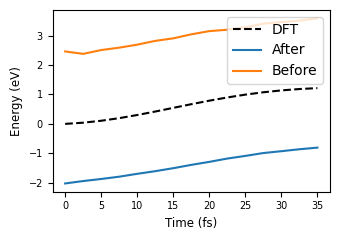

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = results.query('traj == "dft_n=23_T=300K-min_1634248.xyz"')

ax.plot(subset['frame'] * 0.1 * 25, subset['energy_dft'] - subset['energy_dft'].iloc[0], 'k--', label='DFT')
ax.plot(subset['frame'] * 0.1 * 25, subset['energy_ml'] - subset['energy_dft'].iloc[0], label='After')
ax.plot(subset['frame'] * 0.1 * 25, subset['energy_ml-init'] - subset['energy_dft'].iloc[0], label='Before')

#ax.set_xlim([50, 70])
#ax.set_ylim([-1, 1])

ax.legend()

ax.set_xlabel('Time (fs)')
ax.set_ylabel('Energy (eV)')

fig.tight_layout()

In [21]:
subset['force_rmsd'].describe()

count    15.000000
mean      1.148582
std       0.120567
min       0.894161
25%       1.073040
50%       1.206989
75%       1.236052
max       1.258079
Name: force_rmsd, dtype: float64

In [22]:
subset['force_rmsd-init'].describe()

count    15.000000
mean      1.481349
std       0.085565
min       1.359121
25%       1.399270
50%       1.490867
75%       1.562028
max       1.585639
Name: force_rmsd-init, dtype: float64

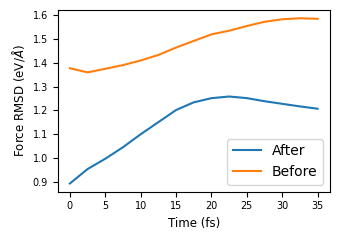

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(subset['frame'] * 0.1 * 25, subset['force_rmsd'], label='After')
ax.plot(subset['frame'] * 0.1 * 25, subset['force_rmsd-init'], label='Before')

#ax.set_xlim([0, 4000])
#ax.set_ylim([-2, 4])

ax.legend()

ax.set_xlabel('Time (fs)')
ax.set_ylabel('Force RMSD (eV/$\AA$)')

fig.tight_layout()

## Run analysis all for experiments
Now that we have these functions, run them for all available experiments

In [24]:
experiment_dirs = [x for x in Path('../runs').iterdir() if x.is_dir() and not x.name.startswith('.')]
print(f'Found {len(experiment_dirs)} experiments')

Found 7 experiments


In [25]:
for experiment in tqdm(experiment_dirs):
    # Clear the old processed results directory
    results_dir = experiment / 'processed-results'
    if results_dir.exists():
        rmtree(results_dir)
    results_dir.mkdir()
    
    # Compute the statistics
    try:
        results = load_results(experiment)
        utilization = get_utilization_over_time(results)
        remove_queue_times(utilization, results)
        compute_cost(utilization, results)

        simulation_results = results.query('task_type == "simulation" and success').copy()
        simulation_results.sort_values('walltime', inplace=True)
        
        overheads = get_overhead_times(results)
        
        benchmark = compare_against_benchmark(experiment)
    except Exception as e:
        print(f'Processing failed for {experiment}. {e}')
        continue
    
    # Store the results
    results.to_csv(results_dir / 'all-tasks.csv', index=False)
    utilization.to_csv(results_dir / 'utilization.csv', index=False)
    simulation_results.to_csv(results_dir / 'simulation-tasks.csv', index=False)
    benchmark.to_csv(results_dir / 'benchmark.csv', index=False)
    overheads.to_csv(results_dir / 'overheads.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.09s/it]


## Match Production Runs to Duplicates
I've repeated the "production runs" several times so we can get better statistics.
This script looks for runs with the same config

In [26]:
for collection in ['prod-runs']:
    for runs in Path(collection).iterdir():
        if runs.name.startswith('.') or not runs.is_dir():
            continue

        # Load the original config
        run_config = json.loads(runs.joinpath('runparams.json').read_text())

        # Find all runs that match it
        matches = [
            str(path.absolute().resolve()) for path in experiment_dirs
            if run_config == json.loads(path.joinpath('runparams.json').read_text())
        ]
        print(f'Found {len(matches)} for {runs.name}')

        # Save the duplicate paths
        with open(runs / 'duplicates.json', 'w') as fp:
            json.dump(matches, fp)

Found 2 for parsl_retrain-8
Found 3 for funcx_retrain-8
Found 2 for baseline_retrain-8
